https://medium.com/ai-insights-cobet/building-mamba-from-scratch-a-comprehensive-code-walkthrough-5db040c28049

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from einops import rearrange
from tqdm import tqdm

import math
import os
import urllib.request
from zipfile import ZipFile

from transformers import AutoTokenizer

torch.autograd.set_detect_anomaly(True)

c:\Users\joeag\Documents\venvs\ml-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


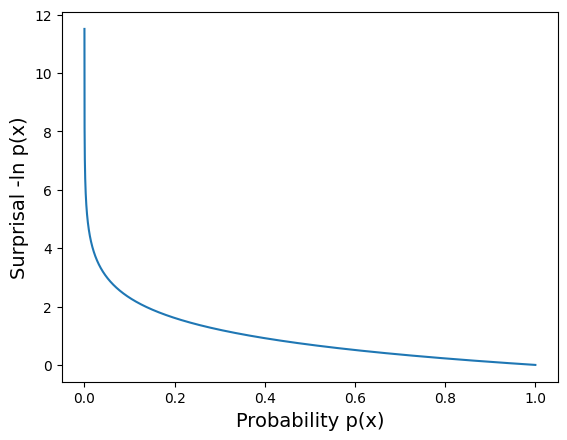

In [6]:
import matplotlib.pyplot as plt
x = torch.arange(0, 1, 0.00001)
y = -x.log()

plt.plot(x, y)
# Big text
plt.xlabel('Probability p(x)', fontsize=14)
plt.ylabel('Surprisal -ln p(x)', fontsize=14)
# plt.ylim(0, 10.0)
plt.show()

In [3]:
USE_MAMBA = 1
DIFFERENT_H_STATES_RECURRENT_UPDATE_MECHANISM = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
class S6(nn.Module):
    def __init__(self, seq_len, d_model, state_size, device):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_model, device=device)
        self.fc2 = nn.Linear(d_model, state_size, device=device)
        self.fc3 = nn.Linear(d_model, state_size, device=device)

        self.seq_len = seq_len
        self.d_model = d_model
        self.state_size = state_size

        self.A = nn.Parameter(F.normalize(torch.ones(d_model, state_size, device=device), p=2, dim=-1))
        nn.init.xavier_uniform_(self.A)

        self.B = torch.zeros(batch_size, self.seq_len, self.state_size, device=device)
        self.C = torch.zeros(batch_size, self.seq_len, self.state_size, device=device)

        self.delta = torch.zeros(batch_size, self.seq_len, self.d_model, device=device)
        self.dA = torch.zeros(batch_size, self.seq_len, self.d_model, self.state_size, device=device)
        self.dB = torch.zeros(batch_size, self.seq_len, self.d_model, self.state_size, device=device)

        self.h = torch.zeros(batch_size, self.seq_len, self.d_model, self.state_size, device=device)
        self.y = torch.zeros(batch_size, self.seq_len, self.d_model, device=device)

    
    def discretisation(self):
        self.dB = torch.einsum("bld,bln->bldn", self.delta, self.B)
        self.dA = torch.exp(torch.einsum("bld,dn->bldn", self.delta, self.A))
        # return self.dA, self.dB
    
    def forward(self, x):
        self.delta = F.softplus(self.fc1(x))
        self.B = self.fc2(x)
        self.C = self.fc3(x)


        self.discretisation()

        if DIFFERENT_H_STATES_RECURRENT_UPDATE_MECHANISM:

            global current_batch_size
            current_batch_size = x.shape[0]

            if self.h.shape[0] != current_batch_size:
                different_batch_size = True
                h_new = torch.einsum('bldn,bldn->bldn', self.dA, self.h[:current_batch_size, ...]) + rearrange(x, "b l d -> b l d 1") * self.dB

            else:
                different_batch_size = False
                h_new = torch.einsum('bldn,bldn->bldn', self.dA, self.h) + rearrange(x, "b l d -> b l d 1") * self.dB

            self.y = torch.einsum('bln,bldn->bld', self.C, h_new)

            global temp_buffer
            temp_buffer = h_new.detach().clone() if not self.h.requires_grad else h_new.clone()

            return self.y
        
        else:

            h = torch.zeros(x.size(0), self.seq_len, self.d_model, self.state_size, device=x.device)
            h = torch.einsum('bldn,bldn->bldn', self.dA, h) + rearrange(x, "b l d -> b l d 1") * self.dB

            y = torch.einsum('bln,bldn->bld', self.C, h)

            return y


class RMSNorm(nn.Module):
    def __init__(self, d_model, device, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model, device=device))

    def forward(self, x):
        normalised = x * torch.rsqrt(x.square().mean(-1, keepdim=True) + self.eps)
        scaled = normalised * self.weight
        return scaled


class MambaBlock(nn.Module):
    def __init__(self, seq_len, d_model, state_size, device):
        super().__init__()

        self.inp_proj = nn.Linear(d_model, 2*d_model, device=device)
        self.out_proj = nn.Linear(2*d_model, d_model, device=device)
        self.out_proj.bias._no_weight_decay = True
        nn.init.constant_(self.out_proj.bias, 1.0)

        self.D = nn.Linear(d_model, 2*d_model, device=device)

        self.S6 = S6(seq_len, 2*d_model, state_size, device)

        self.conv = nn.Conv1d(seq_len, seq_len, kernel_size=3, padding=1, device=device)
        self.conv_linear = nn.Linear(2*d_model, 2*d_model, device=device)

        self.norm = RMSNorm(d_model, device=device)

    def forward(self, x):

        inp = self.norm(x)
        x = self.inp_proj(inp)

        x = F.silu(self.conv(x))
        x = self.conv_linear(x)

        x_ssm = F.silu(self.S6(x))
        x_res = F.silu(self.D(inp))
        x = x_ssm * x_res

        return self.out_proj(x)
    
class Mamba(nn.Module):
    def __init__(self, seq_len, d_model, state_size, device):
        super().__init__()
        self.blocks = nn.Sequential(*[
            MambaBlock(seq_len, d_model, state_size, device),
            MambaBlock(seq_len, d_model, state_size, device),
            MambaBlock(seq_len, d_model, state_size, device),
        ])

    def forward(self, x):
        return self.blocks(x)

In [34]:
d_model = 8
state_size = 128
seq_len = 100
batch_size = 256
last_batch_size = 81
current_batch_size = batch_size
different_batch_size = False
h_new = None
temp_buffer = None

model = Mamba(seq_len, d_model, state_size, device)

x = torch.randn(batch_size, seq_len, d_model, device=device)
norm = RMSNorm(d_model, device=device)
x = norm(x)
out = model(x)
out.shape

torch.Size([256, 100, 8])

In [35]:
class Enwiki8Dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.data.items()}
        return item

In [36]:
# Define a function for padding
def pad_sequences_3d(sequences, max_len=None, pad_value=0):
    # Assuming sequences is a tensor of shape (batch_size, seq_len, feature_size)
    batch_size, seq_len, feature_size = sequences.shape

    if max_len is None:
        max_len = seq_len + 1


    # Initialize padded_sequences with the pad_value
    padded_sequences = torch.full((batch_size, max_len, feature_size), fill_value=pad_value, dtype=sequences.dtype, device=sequences.device)
    # Pad each sequence to the max_len
    padded_sequences[:, :seq_len, :] = sequences

    return padded_sequences

In [37]:
def train(model, tokenizer, data_loader, optimizer, criterion, device, max_grad_norm=1.0, DEBUGGING_IS_ON=False):
    model.train()
    total_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()

        input_data = batch['input_ids'].clone().to(device)
        attention_mask = batch['attention_mask'].clone().to(device)

        # In most sequence modeling tasks, like language modeling, the target should be the next token
        # in the sequence rather than the input token itself.
        # This is because the model's goal is to predict the next word given the previous words.
        # Shift the input data by one position to get the target, so that each target token
        # is the next token following the input token.
        target = input_data[:, 1:]
        input_data = input_data[:, :-1]

        # Pad all the sequences in the batch:
        input_data = pad_sequences_3d(input_data, pad_value=tokenizer.pad_token_id)
        target = pad_sequences_3d(target, max_len=input_data.size(1), pad_value=tokenizer.pad_token_id)

        if USE_MAMBA:
            output = model(input_data)
            loss = criterion(output, target)

        loss.backward(retain_graph=True)

        # Clip gradients: gradients are modified in place
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        for name, param in model.named_parameters():
           if 'out_proj.bias' not in name:
               # clip weights but not bias for out_proj
               torch.nn.utils.clip_grad_norm_(param, max_norm=max_grad_norm)

        if DEBUGGING_IS_ON:
            for name, parameter in model.named_parameters():
                if parameter.grad is not None:
                    print(f"{name} gradient: {parameter.grad.data.norm(2)}")
                else:
                    print(f"{name} has no gradient")

        if USE_MAMBA and DIFFERENT_H_STATES_RECURRENT_UPDATE_MECHANISM:
            model.S6.h[:current_batch_size, ...].copy_(temp_buffer)

        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(data_loader)

In [38]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            input_data = batch['input_ids'].clone().detach().to(device)
            attention_mask = batch['attention_mask'].clone().detach().to(device)

            # In most sequence modeling tasks, like language modeling, the target should be the next token
            # in the sequence rather than the input token itself.
            # This is because the model's goal is to predict the next word given the previous words.
            # Shift the input data by one position to get the target, so that each target token
            # is the next token following the input token.
            target = input_data[:, 1:]
            input_data = input_data[:, :-1]

            # Pad all the sequences in the batch:
            input_data = pad_sequences_3d(input_data, pad_value=tokenizer.pad_token_id)
            target = pad_sequences_3d(target, max_len=input_data.size(1), pad_value=tokenizer.pad_token_id)

            if USE_MAMBA:
                output = model(input_data)
                loss = criterion(output, target)
            total_loss += loss.item()
    return total_loss / len(data_loader)

In [39]:
def calculate_perplexity(loss):
    return math.exp(loss)

In [40]:
def load_enwiki8_dataset():
    print(f"Download and extract enwiki8 data")
    url = "http://mattmahoney.net/dc/enwik8.zip"
    urllib.request.urlretrieve(url, "enwik8.zip")

    with ZipFile("enwik8.zip") as f:
        data = f.read("enwik8").decode("utf-8")

    return data

In [41]:
# Tokenize and encode the dataset
def encode_dataset(tokenizer, text_data):
    def batch_encode(tokenizer, text_data, batch_size=1000):
        # Tokenize in batches
        batched_input_ids = []
        for i in range(0, len(text_data), batch_size):
            batch = text_data[i:i+batch_size]
            inputs = tokenizer(batch, add_special_tokens=True, truncation=True,
                               padding='max_length', max_length=seq_len,
                               return_tensors='pt')
            batched_input_ids.append(inputs['input_ids'])
        return torch.cat(batched_input_ids)

    # Assuming enwiki8_data is a list of sentences
    input_ids = batch_encode(tokenizer, enwiki8_data)

    # vocab_size is the number of unique tokens in the tokenizer's vocabulary
    global vocab_size
    vocab_size = len(tokenizer.vocab)  # Note that for some tokenizers, we might access the vocab directly
    print(f"vocab_size = {vocab_size}")

    # Create an embedding layer
    # embedding_dim is the size of the embedding vectors (MAMBA model's D)
    embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model)

    # Pass `input_ids` through the embedding layer
    # This will change `input_ids` from shape [B, L] to [B, L, D]
    #encoded_input = embedding_layer(input_ids)   ## this eats memory, so use batched_embedding_calls instead
    def batch_embedding_calls(input_ids, embedding_layer, batch_size=256):
        # Check if input_ids is already a tensor, if not convert it
        if not isinstance(input_ids, torch.Tensor):
            input_ids = torch.tensor(input_ids, dtype=torch.long)

        # Calculate the number of batches needed
        num_batches = math.ceil(input_ids.size(0) / batch_size)

        # List to hold the output embeddings
        output_embeddings = []

        # Process each batch
        for i in range(num_batches):
            # Calculate start and end indices for the current batch
            start_idx = i * batch_size
            end_idx = start_idx + batch_size

            # Get the batch
            input_id_batch = input_ids[start_idx:end_idx]

            # Call the embedding layer
            with torch.no_grad():  # No need gradients for this operation
                batch_embeddings = embedding_layer(input_id_batch)

            # Append the result to the list
            output_embeddings.append(batch_embeddings)

        # Concatenate the embeddings from each batch into a single tensor
        all_embeddings = torch.cat(output_embeddings, dim=0)

        return all_embeddings

    # `input_ids` is a list or tensor of the input IDs and `embedding_layer` is model's embedding layer
    if USE_MAMBA:
        # Set `batch_size` to a value that works for memory constraints
        encoded_inputs = batch_embedding_calls(input_ids, embedding_layer, batch_size=1).float()

    attention_mask = (input_ids != tokenizer.pad_token_id).type(input_ids.dtype)

    return encoded_inputs, attention_mask

In [42]:
# Load a pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json: 100%|██████████| 48.0/48.0 [00:00<?, ?B/s]
config.json: 100%|██████████| 570/570 [00:00<?, ?B/s] 
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 1.32MB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 1.93MB/s]


In [43]:
# Assuming encoded_inputs is a preprocessed tensor of shape [num_samples, seq_len, d_model]
encoded_inputs_file = 'encoded_inputs_mamba.pt'


if os.path.exists(encoded_inputs_file):
    print("Loading pre-tokenized data...")
    encoded_inputs = torch.load(encoded_inputs_file)
else:
    print("Tokenizing raw data...")
    enwiki8_data = load_enwiki8_dataset()
    encoded_inputs, attention_mask = encode_dataset(tokenizer, enwiki8_data)
    torch.save(encoded_inputs, encoded_inputs_file)
    print(f"finished tokenizing data")


# Combine into a single dictionary
data = {
    'input_ids': encoded_inputs,
    'attention_mask': attention_mask
}

# Split the data into train and validation sets
total_size = len(data['input_ids'])
train_size = int(total_size * 0.8)

train_data = {key: val[:train_size] for key, val in data.items()}
val_data = {key: val[train_size:] for key, val in data.items()}

train_dataset = Enwiki8Dataset(train_data)
val_dataset = Enwiki8Dataset(val_data)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Initialize the model

model = Mamba(seq_len, d_model, state_size, device).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-6)

# Training loop
num_epochs = 25  # Number of epochs to train for

for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
    train_loss = train(model, tokenizer, train_loader, optimizer, criterion, device, max_grad_norm=10.0, DEBUGGING_IS_ON=False)
    val_loss = evaluate(model, val_loader, criterion, device)
    val_perplexity = calculate_perplexity(val_loss)
    print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Perplexity: {val_perplexity:.4f}')

Tokenizing raw data...
Download and extract enwiki8 data
vocab_size = 30522
finished tokenizing data


  4%|▍         | 1/25 [00:41<16:27, 41.15s/it]

Epoch: 1, Training Loss: 8.8437, Validation Loss: 8.6865, Validation Perplexity: 5922.4782


  8%|▊         | 2/25 [01:20<15:25, 40.23s/it]

Epoch: 2, Training Loss: 8.8296, Validation Loss: 8.5702, Validation Perplexity: 5272.3901


 12%|█▏        | 3/25 [01:59<14:34, 39.77s/it]

Epoch: 3, Training Loss: 7.8347, Validation Loss: 5.4794, Validation Perplexity: 239.6987


 16%|█▌        | 4/25 [02:39<13:52, 39.65s/it]

Epoch: 4, Training Loss: -5.9380, Validation Loss: -21.7479, Validation Perplexity: 0.0000


 20%|██        | 5/25 [03:18<13:12, 39.61s/it]

Epoch: 5, Training Loss: -49.6760, Validation Loss: -80.3540, Validation Perplexity: 0.0000


 24%|██▍       | 6/25 [03:58<12:31, 39.56s/it]

Epoch: 6, Training Loss: -134.6293, Validation Loss: -189.7020, Validation Perplexity: 0.0000


 28%|██▊       | 7/25 [04:37<11:51, 39.51s/it]

Epoch: 7, Training Loss: -278.9517, Validation Loss: -370.2170, Validation Perplexity: 0.0000


 32%|███▏      | 8/25 [05:17<11:11, 39.50s/it]

Epoch: 8, Training Loss: -513.5786, Validation Loss: -663.9566, Validation Perplexity: 0.0000


 36%|███▌      | 9/25 [05:56<10:31, 39.44s/it]

Epoch: 9, Training Loss: -891.1474, Validation Loss: -1134.8793, Validation Perplexity: 0.0000


 40%|████      | 10/25 [06:36<09:51, 39.43s/it]

Epoch: 10, Training Loss: -1487.8922, Validation Loss: -1878.2194, Validation Perplexity: 0.0000


 44%|████▍     | 11/25 [07:15<09:11, 39.40s/it]

Epoch: 11, Training Loss: -2422.2782, Validation Loss: -3043.9231, Validation Perplexity: 0.0000


 48%|████▊     | 12/25 [07:54<08:32, 39.39s/it]

Epoch: 12, Training Loss: -3879.2015, Validation Loss: -4857.3017, Validation Perplexity: 0.0000


 52%|█████▏    | 13/25 [08:34<07:52, 39.39s/it]

Epoch: 13, Training Loss: -6109.1288, Validation Loss: -7624.1411, Validation Perplexity: 0.0000


 56%|█████▌    | 14/25 [09:13<07:12, 39.36s/it]

Epoch: 14, Training Loss: -9502.0034, Validation Loss: -11820.2715, Validation Perplexity: 0.0000


 60%|██████    | 15/25 [09:52<06:33, 39.38s/it]

Epoch: 15, Training Loss: -14611.1538, Validation Loss: -18136.4497, Validation Perplexity: 0.0000


 64%|██████▍   | 16/25 [10:32<05:54, 39.37s/it]

Epoch: 16, Training Loss: -22251.5789, Validation Loss: -27535.1717, Validation Perplexity: 0.0000


 68%|██████▊   | 17/25 [11:11<05:15, 39.39s/it]

Epoch: 17, Training Loss: -33529.3880, Validation Loss: -41334.8787, Validation Perplexity: 0.0000


 72%|███████▏  | 18/25 [11:50<04:35, 39.38s/it]

Epoch: 18, Training Loss: -50046.2264, Validation Loss: -61496.8943, Validation Perplexity: 0.0000


 76%|███████▌  | 19/25 [12:30<03:56, 39.39s/it]

Epoch: 19, Training Loss: -74003.3329, Validation Loss: -90775.7302, Validation Perplexity: 0.0000


 80%|████████  | 20/25 [13:09<03:16, 39.37s/it]

Epoch: 20, Training Loss: -108687.3361, Validation Loss: -132969.1465, Validation Perplexity: 0.0000


 84%|████████▍ | 21/25 [13:49<02:37, 39.41s/it]

Epoch: 21, Training Loss: -158385.8005, Validation Loss: -193252.4986, Validation Perplexity: 0.0000


 88%|████████▊ | 22/25 [14:28<01:58, 39.39s/it]

Epoch: 22, Training Loss: -229383.6311, Validation Loss: -278797.5958, Validation Perplexity: 0.0000


 92%|█████████▏| 23/25 [15:08<01:18, 39.45s/it]

Epoch: 23, Training Loss: -329729.1901, Validation Loss: -399864.6446, Validation Perplexity: 0.0000


 96%|█████████▌| 24/25 [15:47<00:39, 39.42s/it]

Epoch: 24, Training Loss: -470856.2752, Validation Loss: -569100.1214, Validation Perplexity: 0.0000


100%|██████████| 25/25 [16:26<00:00, 39.48s/it]

Epoch: 25, Training Loss: -667271.3972, Validation Loss: -804622.2829, Validation Perplexity: 0.0000
